# My Dinning Spending Habits
The purpose of this notebook is to examine my dinning spending habits during my years in college. I will be using data I receieving from Rit Dining from 08/2021 to 1/2022.

## Imports

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Step One: Gathering the Data

In [183]:
august_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-08-01_to_2021-08-31.csv')
september_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-09-01_to_2021-09-30.csv')
october_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-10-01_to_2021-10-31.csv')
november_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-11-01_to_2021-11-30.csv')
december_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-12-01_to_2021-12-14.csv')
january_df = pd.read_csv('sample-data/Dining Dollars (Meal Plan)_statement_2021-12-16_to_2022-01-31.csv')


In [184]:
august_df.head(3)

,Date,Description,Amount,Balance
0,8/31/2021 06:20PM,Beanz 1 [1505],-5.29,2624.30
1,8/31/2021 05:52PM,Global Village Cantina & Grille 2 [1591],-9.99,2629.59
2,8/31/2021 12:54PM,GOL_1940_69_BEVERAGE,-2.25,2639.58


### Storing the DataFrame into lists catagorized by their semester

In [185]:
fall_semester = [august_df, september_df, october_df, november_df, december_df]
spring_semester = [january_df]
all_semesters = [fall_semester, spring_semester]

## Step Two: Cleaning the Data

### Helper Functions to Clean Up Unneeded Info in the Description Column

In [186]:
def remove_brackets(row):
    return row.split(' [')[0]

def remove_num_at_end(row):
    if row[len(row)-1].isnumeric(): 
        return row[0:len(row)-2]
    else:
        return row

def remove_bad_suffixes(row):
    row = row.removesuffix(' OnDemand')
    row = row.removesuffix(' - Tablet')
    return row

def clean_up_description(row):
    row = remove_brackets(row)
    row = remove_num_at_end(row)
    row = remove_bad_suffixes(row)
    return row

### Helper Function for Creating New Time Columns

In [187]:
day_of_week_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

def create_time_columns(t):
    return pd.Series({'Year': t.year, 'Month': t.month, 'Day Of Week': t.day_of_week, 'Hour': t.hour})

### Cleaning Up DataFrames and Combining Them Based on Semester

In [188]:
def clean_semester_data(semester):
    for i in range(0, len(semester)):
        semester[i]['Description'] = semester[i]['Description'].apply(clean_up_description)
        semester[i]['Date'] = pd.to_datetime(semester[i]['Date'])
        semester[i].sort_values(by='Date', inplace=True)
        semester[i] = pd.concat([semester[i], semester[i]['Date'].apply(create_time_columns)], axis=1)
        semester[i]['Day Of Week'] = semester[i]['Day Of Week'].map(day_of_week_map)
        semester[i] = semester[i].reset_index()
        semester[i].drop('index', axis=1, inplace=True)
        semester[i] = semester[i][['Description', 'Amount', 'Balance', 'Date', 'Year', 'Month', 'Day Of Week', 'Hour']]
    return semester

def aggregate_semester_data(semester):
    semester = clean_semester_data(semester)

    semester_df = semester[0]
    for index in range(1, len(semester)):
        semester_df = pd.concat([semester_df, semester[index]])

    semester_df = semester_df.reset_index()
    semester_df.drop('index', axis=1, inplace=True)

    return semester_df

In [189]:
fall_semester_df = aggregate_semester_data(fall_semester)
spring_semester_df = aggregate_semester_data(spring_semester)

## Step Three: Modeling and Analysing the Data

### The Fall Semester

In [190]:
fall_semester_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Description  300 non-null    object        
 1   Amount       300 non-null    float64       
 2   Balance      300 non-null    float64       
 3   Date         300 non-null    datetime64[ns]
 4   Year         300 non-null    int64         
 5   Month        300 non-null    int64         
 6   Day Of Week  300 non-null    object        
 7   Hour         300 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 18.9+ KB


In [191]:
fall_semester[0].head()

,Description,Amount,Balance,Date,Year,Month,Day Of Week,Hour
0,Deposit,3020.00,3020.00,2021-08-04 09:01:00,2021,8,Wed,9
1,The Commons,-11.91,3008.09,2021-08-22 15:32:00,2021,8,Sun,15
2,Campus Concessions,-13.00,2995.09,2021-08-22 19:54:00,2021,8,Sun,19
3,Campus Concessions,-13.00,2982.09,2021-08-22 20:23:00,2021,8,Sun,20
4,Brick City Cafe,-19.58,2962.51,2021-08-23 12:39:00,2021,8,Mon,12


In [192]:
fall_semester_df

,Description,Amount,Balance,Date,Year,Month,Day Of Week,Hour
0,Deposit,3020.00,3020.00,2021-08-04 09:01:00,2021,8,Wed,9
1,The Commons,-11.91,3008.09,2021-08-22 15:32:00,2021,8,Sun,15
2,Campus Concessions,-13.00,2995.09,2021-08-22 19:54:00,2021,8,Sun,19
3,Campus Concessions,-13.00,2982.09,2021-08-22 20:23:00,2021,8,Sun,20
4,Brick City Cafe,-19.58,2962.51,2021-08-23 12:39:00,2021,8,Mon,12
...,...,...,...,...,...,...,...,...
295,GOL_2942_67_SNACK,-2.35,22.19,2021-12-13 15:29:00,2021,12,Mon,15
296,GOL_2942_67_SNACK,-1.60,20.59,2021-12-13 15:30:00,2021,12,Mon,15
297,Cafe & Market at Crossroads,-8.29,12.30,2021-12-13 19:17:00,2021,12,Mon,19
298,Ctrl Alt DELi,-6.89,5.41,2021-12-14 11:13:00,2021,12,Tue,11


#### How Much Did I Spend This Semester

In [193]:
fall_semester_df['Balance'].iloc[0] - fall_semester_df['Balance'].iloc[-1]

3020.0

Text(0.5, 1.0, 'Balance over Semester')

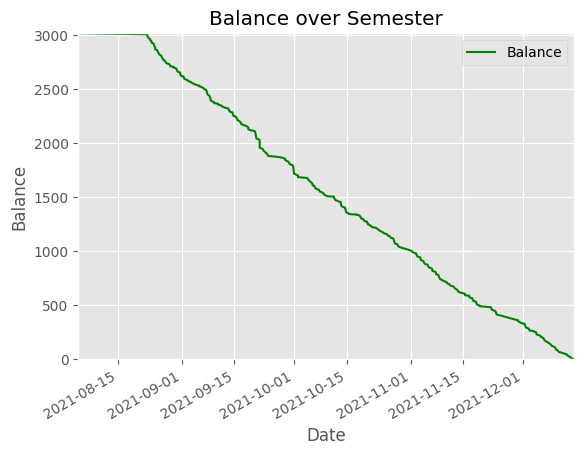

In [194]:
plt.style.use('ggplot')
fall_semester_df.plot.line(x='Date', y='Balance', color='green')
axes = plt.gca()

axes.set_xlim([fall_semester_df['Date'].iloc[0], fall_semester_df['Date'].iloc[-1]])
axes.set_ylim([fall_semester_df['Balance'].iloc[-1], fall_semester_df['Balance'].iloc[0]])
axes.set_ylabel('Balance')
axes.set_title('Balance over Semester')

### The Spring Semester

In [195]:
spring_semester_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Description  24 non-null     object        
 1   Amount       24 non-null     float64       
 2   Balance      24 non-null     float64       
 3   Date         24 non-null     datetime64[ns]
 4   Year         24 non-null     int64         
 5   Month        24 non-null     int64         
 6   Day Of Week  24 non-null     object        
 7   Hour         24 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.6+ KB


In [196]:
spring_semester_df.head()

,Description,Amount,Balance,Date,Year,Month,Day Of Week,Hour
0,Deposit,3020.00,3020.00,2021-12-16 10:18:00,2021,12,Thu,10
1,The Commons,-10.18,3009.82,2022-01-09 12:40:00,2022,1,Sun,12
2,Brick City Cafe,-9.67,3000.15,2022-01-10 07:37:00,2022,1,Mon,7
3,Brick City Cafe,-3.60,2996.55,2022-01-10 07:55:00,2022,1,Mon,7
4,RITz Sports Zone,-9.99,2986.56,2022-01-11 16:27:00,2022,1,Tue,16
